# Práctica 3: Aplicación de Business Intelligence y Minería de Datos

# 1. Carga y Exploración del Dataset

In [15]:
import os
import pandas as pd

# Leer todos los archivos de la carpeta 'emails'
ruta = "emails/"
documentos = []
nombres = []

for archivo in os.listdir(ruta):
    if archivo.endswith(".txt"):
        with open(os.path.join(ruta, archivo), 'r', encoding='utf-8', errors='ignore') as f:
            documentos.append(f.read())
            nombres.append(archivo)

df_original = pd.DataFrame({'archivo': nombres, 'contenido': documentos})
df_original.head()

,archivo,contenido
0,62c15d490d06be2313e5d4840c570dbf9095172e.txt,From: stssdxb@st.unocal.com (Dorin Baru)\nSubj...
1,5e2afa5a50c89fbdd863bd9851c978e6021d361a.txt,From: scott@psy.uwa.oz.au (Scott Fisher)\nSubj...
2,b244e3c38e9146ec260943784fa0c05bfec86503.txt,"From: abou@dam.cee.clarkson.edu (Abou Bakr,Dam..."
3,063e0232997ddffa9ad7648d4b0ab2778e9a026e.txt,From: noye@midway.uchicago.edu (vera shanti no...
4,01627f1c2797f307ee229359e54509470b0b647c.txt,From: ryan_cousineau@compdyn.questor.org (Ryan...


In [16]:
# copiamos del original para trabajar
df = df_original.copy()

# 2. Exploración Inicial

In [11]:
# Número total de documentos
print(f"Número total de documentos: {len(df)}")

# Longitud promedio
df['longitud'] = df['contenido'].apply(len)
print(f"Longitud promedio del texto: {df['longitud'].mean():.2f}")

# Ejemplos de textos
df['contenido'].sample(3).values

Número total de documentos: 18828
Longitud promedio del texto: 1801.11


array(['From: garrett@Ingres.COM (GREP A FRIEND)\nSubject: Re: Bush\'s WI \n\nIn article <1qt61e$d7e@usenet.INS.CWRU.Edu>, an030@cleveland.Freenet.Edu (B writes...\n>In a previous article, garrett@Ingres.COM (THE SKY ALREADY FELL. NOW WHAT?) says:\n>>In article <9304161803.AA23713@inet-gw-2.pa.dec.com>, blh@uiboise.idbsu.edu (Broward L. Horne)         writes...\n>>>\tI strongly urge you to consider moving any savings you \n>>>\thave overseas, into protected bank accounts, while \n>>>\tyou are still able.\n>>> \n>>Have you?\n> \n>        Went to the Post Office on Friday, got my passport apps in.\n>        My savings have already been converted.\n> \nBye.\n> \n\n------------------------------------------------------------------------------\n"Nothing is as inevitable as a mistake whose time has          Garrett Johnson\n come." --Tussman                                           Garrett@Ingres.com\n"The probability of someone watching you is proportional\nto the stupidity of your action.

In [17]:
# dividimos en columnas para tener el compo body limpio
import re

def parse_email(texto):
    # Extraer campo From
    match_from = re.search(r'^From:\s*(.*)', texto, re.MULTILINE)
    from_ = match_from.group(1).strip() if match_from else None

    # Extraer campo Subject
    match_subject = re.search(r'^Subject:\s*(.*)', texto, re.MULTILINE)
    subject = match_subject.group(1).strip() if match_subject else None

    # Determinar si es respuesta
    es_respuesta = subject.lower().startswith("re:") if subject else False

    # Eliminar encabezados (todo hasta la primera línea vacía)
    body = re.split(r'\n\s*\n', texto, maxsplit=1)
    body = body[1].strip() if len(body) > 1 else texto

    # 5. Dividir el cuerpo en líneas
    lineas = body.splitlines()

    # 6. Marcar si cada línea es una cita (empieza con al menos un '>')
    niveles_cita = [len(re.match(r'^(>+)', linea).group(1)) if re.match(r'^(>+)', linea) else 0 for linea in lineas]

    # 7. ¿El correo tiene al menos una cita?
    tiene_cita = any(n > 0 for n in niveles_cita)

    # 8. Nivel máximo de citas encontradas
    nivel_maximo_cita = max(niveles_cita) if niveles_cita else 0
    
    return pd.Series([from_, subject, es_respuesta, body, tiene_cita, nivel_maximo_cita])

# Aplicamos al DataFrame original
df[['from', 'subject', 'es_respuesta', 'body', 'tiene_cita', 'nivel_maximo_cita']] = df['contenido'].apply(parse_email)
df = df.drop(columns=['contenido'])  # opcional
df.head()


,archivo,from,subject,es_respuesta,body,tiene_cita,nivel_maximo_cita
0,62c15d490d06be2313e5d4840c570dbf9095172e.txt,stssdxb@st.unocal.com (Dorin Baru),Re: was:Go Hezbollah!,True,"(Brad Hernlem writes:\n\n\n>Well, you should h...",True,1
1,5e2afa5a50c89fbdd863bd9851c978e6021d361a.txt,scott@psy.uwa.oz.au (Scott Fisher),Re: Manual Shift Bigots,True,jahonen@cc.lut.fi (Jarmo Ahonen) writes:\n\n>k...,True,2
2,b244e3c38e9146ec260943784fa0c05bfec86503.txt,"abou@dam.cee.clarkson.edu (Abou Bakr,Damon 317...",Re: Forsale and Wanted (HD/Fax/Typewriter),True,From article <1pf5qe$b3b@seven-up.East.Sun.COM...,True,1
3,063e0232997ddffa9ad7648d4b0ab2778e9a026e.txt,noye@midway.uchicago.edu (vera shanti noyes),Re: Am I going to Hell?,True,In article <Apr.24.01.09.10.1993.4254@geneva.r...,True,1
4,01627f1c2797f307ee229359e54509470b0b647c.txt,ryan_cousineau@compdyn.questor.org (Ryan Cousi...,Boom! Dog attack!,False,My previous posting on dog attacks must have g...,False,0


Distribución de correos que son respuesta (Re:):
es_respuesta
True     12350
False     6478
Name: count, dtype: int64

Porcentaje de correos que contienen al menos una cita: 50.49%


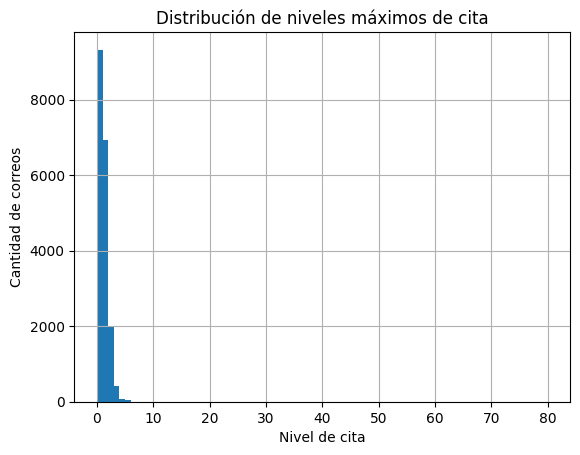

In [22]:
# Distribución de respuestas
print("Distribución de correos que son respuesta (Re:):")
print(df['es_respuesta'].value_counts())

# Correos que contienen citas
print(f"\nPorcentaje de correos que contienen al menos una cita: {df['tiene_cita'].mean() * 100:.2f}%")

# Histograma del nivel máximo de cita
import matplotlib.pyplot as plt

df['nivel_maximo_cita'].hist(bins=range(0, df['nivel_maximo_cita'].max()+2))
plt.title("Distribución de niveles máximos de cita")
plt.xlabel("Nivel de cita")
plt.ylabel("Cantidad de correos")
plt.show()


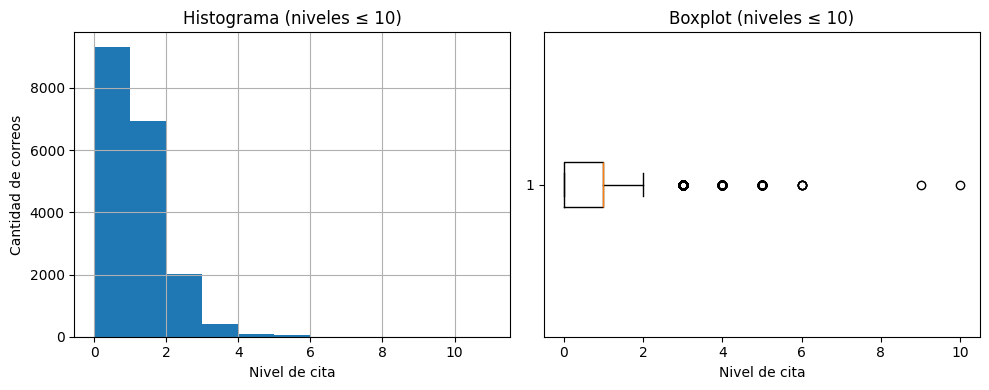

In [23]:
import matplotlib.pyplot as plt

# Filtrar niveles razonables (e.g. hasta 10)
niveles_filtrados = df[df['nivel_maximo_cita'] <= 10]['nivel_maximo_cita']

plt.figure(figsize=(10, 4))

# Histograma
plt.subplot(1, 2, 1)
niveles_filtrados.hist(bins=range(0, 12))
plt.title("Histograma (niveles ≤ 10)")
plt.xlabel("Nivel de cita")
plt.ylabel("Cantidad de correos")

# Boxplot
plt.subplot(1, 2, 2)
plt.boxplot(niveles_filtrados, vert=False)
plt.title("Boxplot (niveles ≤ 10)")
plt.xlabel("Nivel de cita")

plt.tight_layout()
plt.show()


# 3. Preprocesamiento de Texto

Agregamos libreria NLTK que es una libreria con lenguaje humano que nos ayudara a analizar texto

In [5]:
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable


In [24]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

nltk.download('punkt') # un tokenizador pre-entrenado.
nltk.download('stopwords') # identificador se refiere a una lista de palabras vacías (stopwords) en varios idiomas
nltk.download('punkt_tab') # identificador se refiere a un modelo adicional para el tokenizador "punkt"

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

def limpiar_texto(texto):
    texto = texto.lower() # ponemos en minusculas
    tokens = word_tokenize(texto) # dividimos en palabras individuales
    tokens = [t for t in tokens if t.isalpha()] # filtramos - solo texto
    tokens = [t for t in tokens if t not in stop_words] # quitamos - palabras muy comunes que no aportan significado como "el", "la", "y"
    tokens = [stemmer.stem(t) for t in tokens] # aplicacmos stemming - reducimos las palabras a su raíz (por ejemplo: "jugando" → "jug")
    return " ".join(tokens)

df['texto_limpio'] = df['body'].apply(limpiar_texto)
df[['archivo', 'texto_limpio']].head()


[nltk_data] Downloading package punkt to /home/gaston/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/gaston/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/gaston/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,archivo,texto_limpio
0,62c15d490d06be2313e5d4840c570dbf9095172e.txt,brad hernlem write well note cheer attack isra...
1,5e2afa5a50c89fbdd863bd9851c978e6021d361a.txt,jahonen jarmo ahonen write kissan john kissan ...
2,b244e3c38e9146ec260943784fa0c05bfec86503.txt,articl jorg jorg lach sun bos hardwar look buy...
3,063e0232997ddffa9ad7648d4b0ab2778e9a026e.txt,articl stoney stanley toney write muslim fear ...
4,01627f1c2797f307ee229359e54509470b0b647c.txt,previous post dog attack must generat bad karm...


# 4. Vectorización del Texto (TF-IDF)

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, min_df=5)
X = vectorizer.fit_transform(df['texto_limpio'])

print(f"Shape del TF-IDF: {X.shape}")


Shape del TF-IDF: (18828, 18680)


# 5. Clustering No Supervisado (K-Means)

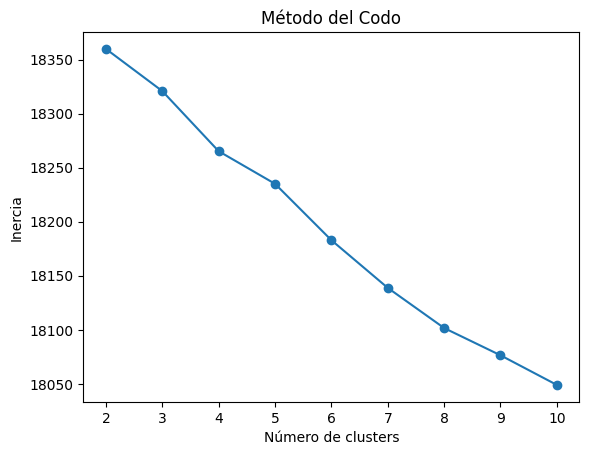

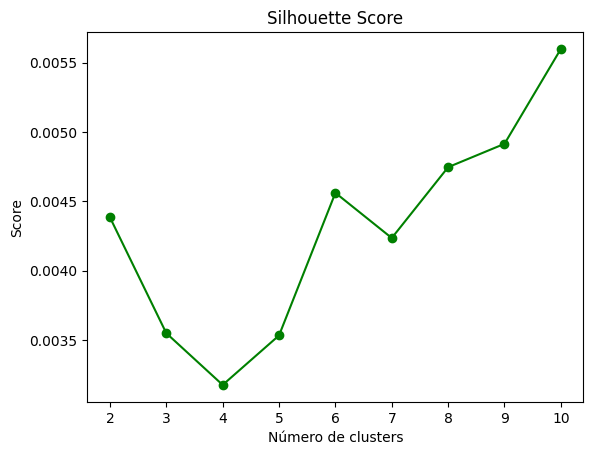

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Elbow Method
inertia = []
sil_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X, kmeans.labels_))

# Graficar resultados
plt.plot(K, inertia, marker='o')
plt.title("Método del Codo")
plt.xlabel("Número de clusters")
plt.ylabel("Inercia")
plt.show()

plt.plot(K, sil_scores, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("Número de clusters")
plt.ylabel("Score")
plt.show()


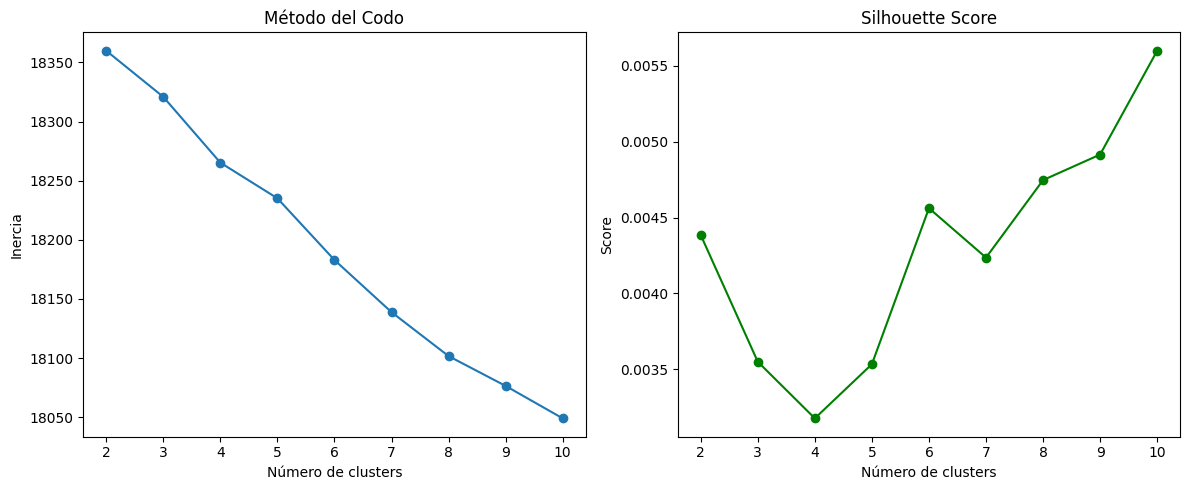

In [30]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K, inertia, marker='o')
plt.title("Método del Codo")
plt.xlabel("Número de clusters")
plt.ylabel("Inercia")

plt.subplot(1, 2, 2)
plt.plot(K, sil_scores, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("Número de clusters")
plt.ylabel("Score")

plt.tight_layout()
plt.show()

# 6. Aplicación Final del Modelo

In [28]:
# Elegimos el mejor k (por ejemplo, k=4 basado en los gráficos)
modelo_final = KMeans(n_clusters=4, random_state=42)
df['cluster'] = modelo_final.fit_predict(X)

# Ver ejemplos por cluster
for c in sorted(df['cluster'].unique()):
    print(f"\n--- Ejemplos del Cluster {c} ---")
    print(df[df['cluster'] == c]['body'].sample(1).values[0][:500])



--- Ejemplos del Cluster 0 ---
I am selling a Western Digital 212 meg IDE HD, the Caviar 2200 model.  The 
access time is <15 ms, and it has a built in cache.  It is BRAND NEW, still
in the original static bag.  Asking $275, obo.

--- Ejemplos del Cluster 1 ---
Hello Motif World,

a few days ago I posted my announcement for an update of Motif++. I got
several requests to send the bindings per e-mail, and I know of several people
who have been using Motif++, and there are probably a number of people I am
not aware of who are also using Motif++.

My question is:

How many people 'out there' would be interested to join a mailing-list, where
people can ask questions about Motif++, swap stories, and give new ideas about
new directions and improvements for t

--- Ejemplos del Cluster 2 ---
I would like to keep track of X development on:
- A/UX
- ULTRIX
- OpenWindows
Currently I cannot use the newsgroup comp.windows.x 
and would like to use the Email based info. 
Thanks,


Folkert Boonstra 


# 7. Reducción de Dimensionalidad y Visualización (opcional)

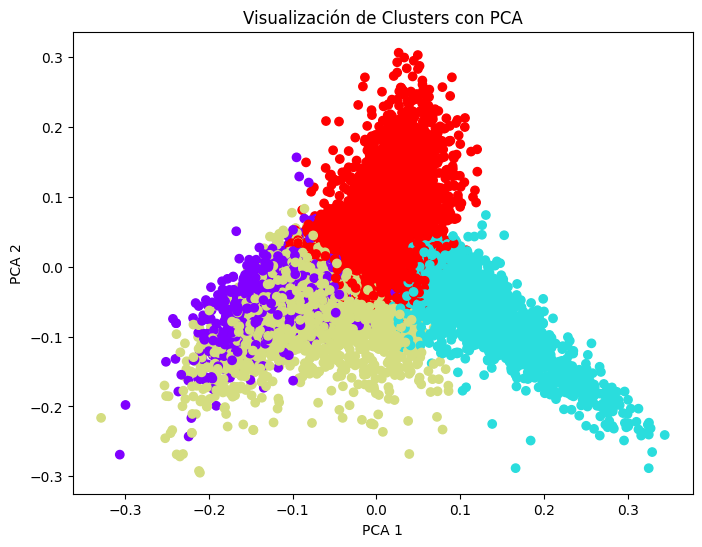

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['cluster'], cmap='rainbow')
plt.title("Visualización de Clusters con PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [31]:
df.groupby('cluster')[['es_respuesta', 'tiene_cita', 'nivel_maximo_cita']].mean()


,es_respuesta,tiene_cita,nivel_maximo_cita
cluster,,,
0,0.458832,0.348346,0.442646
1,0.819817,0.708276,1.006643
2,0.448162,0.325196,0.437914
3,0.691963,0.512887,0.712104
